In [1]:
import geopandas as gpd
import geopy
import requests
import json
import rasterio as rs
import rioxarray 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline



##Spijker 31, 2910 Essen

/home/arfa/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
addr = "Spijker 31, 2910 Essen"
loc = gpd.tools.geocode(addr)
loc

,geometry,address
0,POINT (4.47512 51.45711),"31, Spijker, 2910, Spijker, Essen, Antwerpen, ..."


In [3]:
address =  "Spijker 31, 2910 Essen"

In [4]:
def details(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']['coordinates']]
    
    return info

In [5]:
info = details(address)
info


{'address': 'Spijker 31, 2910 Essen',
 'x_value': 157393.73,
 'y_value': 238612.74,
 'street': 'Spijker',
 'house_number': '31',
 'postcode': '2910',
 'municipality': 'Essen',
 'polygon': [[[[157385.27265635878, 238620.1483275406],
    [157385.28379235417, 238608.35287153348],
    [157396.21768036485, 238608.20400753245],
    [157396.18030436337, 238604.83991153166],
    [157405.4515363723, 238604.65443953127],
    [157405.51624037325, 238607.88957553357],
    [157403.94593637437, 238607.92093553394],
    [157403.95796836913, 238609.54890353233],
    [157398.62830436975, 238609.76023153588],
    [157398.51592036337, 238620.12042354047],
    [157385.27265635878, 238620.1483275406]]]]}

In [6]:
polygon = info["polygon"]
polygon

[[[[157385.27265635878, 238620.1483275406],
   [157385.28379235417, 238608.35287153348],
   [157396.21768036485, 238608.20400753245],
   [157396.18030436337, 238604.83991153166],
   [157405.4515363723, 238604.65443953127],
   [157405.51624037325, 238607.88957553357],
   [157403.94593637437, 238607.92093553394],
   [157403.95796836913, 238609.54890353233],
   [157398.62830436975, 238609.76023153588],
   [157398.51592036337, 238620.12042354047],
   [157385.27265635878, 238620.1483275406]]]]

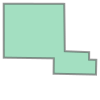

In [7]:
from shapely import geometry

poly = geometry.Polygon(polygon[0][0])
poly

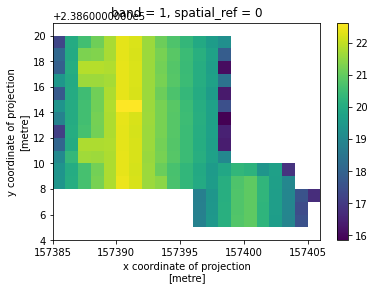

In [9]:
clipped = [ {'type': 'Polygon','coordinates': polygon[0]}]
dsm = rioxarray.open_rasterio('DSM_k01.tif', masked =True).rio.clip(clipped, from_disk=True)
dsm.plot()

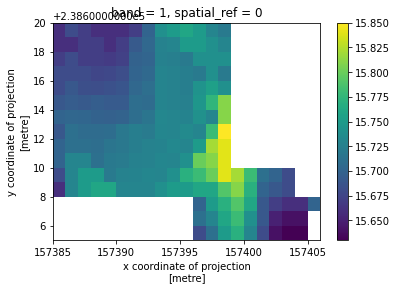

In [10]:
dtm = rioxarray.open_rasterio('DTM_k01.tif',masked=True).rio.clip(clipped)
dtm.plot()

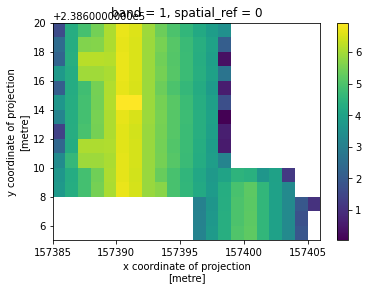

In [11]:
clipped_chm = dsm - dtm 
clipped_chm.plot()

In [12]:
chm = clipped_chm[0]
chm.shape

chm1 = np.where(np.isnan(chm), 0, chm)

chm_ = np.pad(chm1, pad_width = 1, mode = "constant", constant_values = 0)
chm_
rchm = np.fliplr(chm_)

In [13]:
chm_.shape
#rchm.shape

(17, 23)

<IPython.core.display.Javascript object>


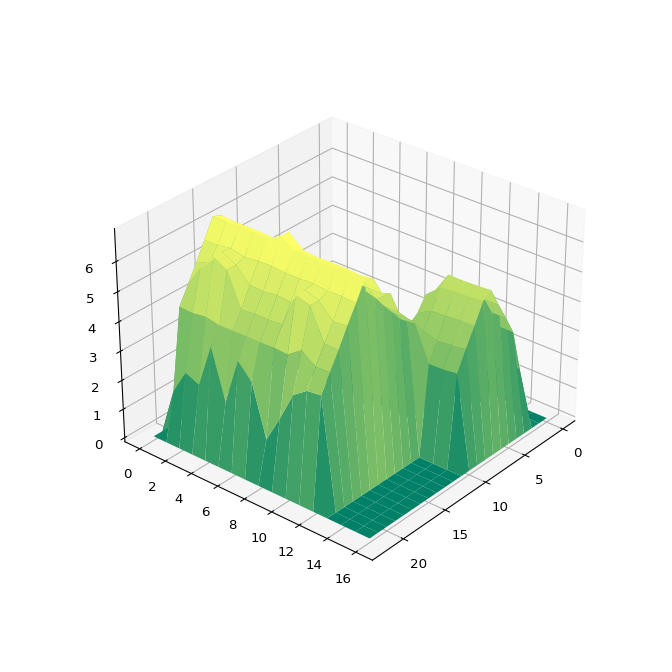

MovieWriter imagemagick unavailable; using Pillow instead.


In [14]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%matplotlib notebook

ny = rchm.shape[0]
nx = rchm.shape[1]
x = range(nx)
y = range(ny)
x1, y1 = np.meshgrid(x, y)
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
chm3d = ax.plot_surface(x1, y1, rchm,cmap = cm.summer, linewidth=0.1,)

#plt.show()

def rotate(angle):
    ax.view_init(azim=angle) 
    plt.draw()
    plt.pause(.001)
    
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=100)
rot_animation.save('Essen_House_no_31.gif', writer='imagemagick')
plt.show()